In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

In [2]:
dev = qml.device('cirq.simulator', wires=2)

In [69]:
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)
    
def D_I(w):
    U1(w,0)
    
def G(w):
    U1(w,0)


def D_M(w):
    U2(w,0,1)
    
#use same structure as for generator    
def R(w):
    U1(w,0)

In [70]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    D_I(disc_weights[0:3])
    R(real_params)
    D_M(disc_weights[3:18])
    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    D_I(disc_weights[0:3])
    G(gen_weights)
    D_M(disc_weights[3:18])
    return qml.expval(qml.PauliZ(1))

In [71]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

In [72]:
np.random.seed(1)
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=3)

np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=3)

np.random.seed(15)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=18)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)

disc_weights=np.array(list(init_disc_weights), requires_grad=True)

In [73]:
opt1=qml.GradientDescentOptimizer(stepsize=0.05)
opt2=qml.GradientDescentOptimizer(stepsize=0.05)

Metrics for the operators. (since it's 1 qubit space I'm computing the Hilbert Schmidt norm manually)

In [74]:
dev_state = qml.device('default.qubit', wires=1)

@qml.qnode(dev_state)
def real_0_circuit(real_params):
    R(real_params)
    return qml.state()

@qml.qnode(dev_state)
def real_1_circuit(real_params):
    qml.PauliX(0)
    R(real_params)
    return qml.state()

@qml.qnode(dev_state)
def gen_0_circuit(gen_weights):
    G(gen_weights)
    return qml.state()

@qml.qnode(dev_state)
def gen_1_circuit(gen_weights):
    qml.PauliX(0)
    G(gen_weights)
    return qml.state()

In [75]:
def Hilbert_Schmidt(real_params, gen_weights):
    ψ_R0 = qt.Qobj(real_0_circuit(real_params).numpy())
    ψ_G0 = qt.Qobj(gen_0_circuit(gen_weights).numpy())
    
    ψ_R1 = qt.Qobj(real_1_circuit(real_params).numpy())
    ψ_G1 = qt.Qobj(gen_1_circuit(gen_weights).numpy())
    
    diff_0 = ψ_R0-ψ_G0
    diff_1 = ψ_R1-ψ_G1
    
    norm = (diff_0).norm()+(diff_1).norm()
    
    return norm

In [76]:
Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
norm = []

costD = lambda: disc_cost(disc_weights)
costG = lambda: gen_cost(gen_weights)

#print("gen_weights", gen_weights)
#print("disc_weights", disc_weights)

for turn in range(300):
    print("Begin "+ str(turn) + " discriminator optimization")
    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    for step in range(5): #The actual ratio should be 20 to 1, according to what we discussed
        #opt.minimize(costD, disc_weights)
        print("Before "+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        #grad_fn_disc=real_disc_circuit_gradient(disc_weights)-gen_disc_circuit_gradient_disc(disc_weights)
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_fn_disc=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        #print("grad_fn_disc", grad_fn_disc)
        print("After"+str(step) + " disc gradient computation of "+str(turn)+ " round of optimization")
        disc_weights=np.array(opt1.apply_grad(grad_fn_disc, disc_weights), requires_grad=True)
        #disc_weights=np.array(opt1.step(disc_cost, disc_weights), requires_grad=True)
        #print("disc_weights", disc_weights)
        print("After"+str(step) + " disc opt update of "+str(turn)+ " round of optimization")

        if step == 4:
            costD_val = costD().numpy()
            print("Step {}: cost = {}".format(step, costD_val))
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)
    print("End of " + str(turn)+" discriminator optimization")    
    print("end of "+ str(turn)+ " optimization ")
            #opt.minimize(costG, gen_weights)
    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)
    print("Begin of "+str(turn)+" generator optimization")
    #print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    #disc_weights=np.array(list(disc_weights), requires_grad=False)
    #gen_weights=np.array(list(gen_weights), requires_grad=True)

    print("Before gen gradient computation")
    #grad_fn_gen=-gen_disc_circuit_gradient_gen(gen_weights)
    grad_fn_gen=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    #print("grad_fn_gen", grad_fn_gen)
    print("After gen gradient computation")
    gen_weights=np.array(opt2.apply_grad(grad_fn_gen, gen_weights), requires_grad=True)
    #gen_weights=np.array(opt2.step(gen_cost, gen_weights), requires_grad=True)
    #print("gen_weights", gen_weights)
    #print("disc_weights", disc_weights)
    print("After gen opt update ")
    costG_val = costG().numpy()
    #print("Step {}: cost = {}".format(step, costG_val))
    Gen_cost += [-costG_val] # P(R|G)
    
 
    norm_step = Hilbert_Schmidt(real_params, gen_weights)
    norm += [norm_step]
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Hilbert Schmidt norm: ",norm_step)
    print("------------------------------")

Begin 0 discriminator optimization
Before 0 disc gradient computation of 0 round of optimization
After0 disc gradient computation of 0 round of optimization
After0 disc opt update of 0 round of optimization
Before 1 disc gradient computation of 0 round of optimization
After1 disc gradient computation of 0 round of optimization
After1 disc opt update of 0 round of optimization
Before 2 disc gradient computation of 0 round of optimization
After2 disc gradient computation of 0 round of optimization
After2 disc opt update of 0 round of optimization
Before 3 disc gradient computation of 0 round of optimization
After3 disc gradient computation of 0 round of optimization
After3 disc opt update of 0 round of optimization
Before 4 disc gradient computation of 0 round of optimization
After4 disc gradient computation of 0 round of optimization
After4 disc opt update of 0 round of optimization
Step 4: cost = 0.04050731658935547
End of 0 discriminator optimization
end of 0 optimization 
Begin of 0 

In [77]:
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
norm = np.array(norm)

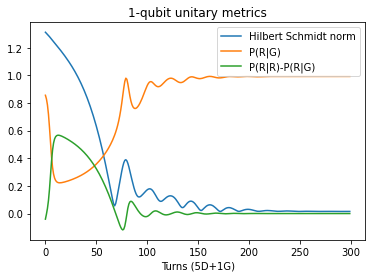

In [78]:
plt.plot(norm, label='Hilbert Schmidt norm')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.xlabel('Turns (5D+1G)') 
plt.title("1-qubit unitary metrics")
plt.legend()
plt.savefig('1qubitunitary.png', format='png')